In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, WhiteKernel, ConstantKernel, DotProduct


In [3]:
msa_vmt = pd.read_csv('../../../results/historical_VMT_msa_basedon2022.csv',index_col=None) 
msa_vmt = msa_vmt.set_index('Year')
msa_vmt = msa_vmt[::-1]
msa_vmt

# Define new column names
new_column_names = ['New Haven (billion miles)', 'Hartford (billion miles)', 'Bridgeport (billion miles)']

# Assign new column names to the DataFrame
msa_vmt.columns = new_column_names

msa_vmt.index.name = 'year'

#msa_vmt.index = pd.to_datetime(msa_vmt.index, format='%Y')
msa_vmt.index.freq = 'AS'
df=msa_vmt

In [5]:
NHM_data = df['New Haven (billion miles)']
y_NHM =NHM_data.values.reshape(-1, 1)
x_NHM = NHM_data.index.to_numpy().reshape(-1, 1)

x_NHM_df = pd.DataFrame(x_NHM, columns=['Year'])

# # Now you can use iloc for indexing
# split_index_x = round(len(x_NHM_df) * 0.9)
# X_train = x_NHM_df.iloc[:split_index_x].copy()
# X_test = x_NHM_df.iloc[split_index_x:].copy()

y_NHM_df = pd.DataFrame(y_NHM, columns=['New Haven (billion miles)'])

# Now you can use iloc for indexing
# split_index_y = round(len(y_NHM_df) * 0.9)
# Y_train = y_NHM_df.iloc[:split_index_y].copy()
# Y_test = y_NHM_df.iloc[split_index_y:].copy()

In [6]:
kernels = [
    C(3.0) * RBF(length_scale=2.0),
    C(3.0) * Matern(length_scale=2.0, nu=1.5)]
    #C(3.0) * RationalQuadratic(length_scale=2.0, alpha=0.1),
    #C(3.0) * ConstantKernel(constant_value=1.0)]
    #C(3.0) * DotProduct(sigma_0=1.0)]
    #C(3.0) * ExpSineSquared(length_scale=2.0, periodicity=1.0)]
    #C(3.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1),
    #C(3.0) * DotProduct() + C(1.0) * RBF(length_scale=2.0)]

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

X = x_NHM
y = y_NHM

# List to store the best scores and corresponding kernels and parameters
results = []

# Logarithmically spaced values for length scale and alpha
length_scales = np.logspace(-2, 2, 5)
alphas = np.logspace(-2, 2, 5)

# length_scales = np.array([-0.1,0,1,2,4,10])
# alphas = np.array([-0.1,0,1,2,4,10])

# Define the mean absolute percentage error function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

for kernel in kernels:
    for length_scale in length_scales:
        for alpha in alphas:
            try:
                # Set the length scale parameter correctly for different kernels
                if hasattr(kernel.k2, 'length_scale'):
                    kernel.k2.length_scale = length_scale
                elif hasattr(kernel.k1, 'length_scale'):
                    kernel.k1.length_scale = length_scale
                
                # Set the alpha parameter if the kernel is RationalQuadratic
                if isinstance(kernel.k2, RationalQuadratic):
                    kernel.k2.alpha = alpha
                elif isinstance(kernel.k1, RationalQuadratic):
                    kernel.k1.alpha = alpha

                rmse_scores = []
                mae_scores = []
                mape_scores = []
                for train_index, test_index in tscv.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
                    gp.fit(X_train, y_train)
                    y_pred, _ = gp.predict(X_test, return_std=True)
                    
                    # Compute the metrics
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    mape = mean_absolute_percentage_error(y_test, y_pred)
                    
                    rmse_scores.append(rmse)
                    mae_scores.append(mae)
                    mape_scores.append(mape)
                
                mean_rmse = np.mean(rmse_scores)
                mean_mae = np.mean(mae_scores)
                mean_mape = np.mean(mape_scores)
                
                results.append((mean_rmse, mean_mae, mean_mape, kernel, kernel.get_params()))
            except Exception as e:
                print(f"An error occurred: {e}")

# Sort results by the RMSE score
results.sort(key=lambda x: x[0])

# Print the top 10 results
print("Top 10 Kernel Configurations:")
for i, (rmse, mae, mape, kernel, params) in enumerate(results[:10]):
    print(f"Rank {i+1}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  MAPE: {mape}")
    print(f"  Kernel: {kernel}")
    print("  Parameters:")
    for param_name, param_value in params.items():
        print(f"    {param_name}: {param_value}")
    print()

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\peiyaozhao\AppData\Loc

Top 10 Kernel Configurations:
Rank 1:
  RMSE: 0.763531518698634
  MAE: 0.6264989654679664
  MAPE: 9.517654104768193
  Kernel: 1.73**2 * Matern(length_scale=100, nu=1.5)
  Parameters:
    k1: 1.73**2
    k2: Matern(length_scale=100, nu=1.5)
    k1__constant_value: 3.0
    k1__constant_value_bounds: (1e-05, 100000.0)
    k2__length_scale: 0.01
    k2__length_scale_bounds: (1e-05, 100000.0)
    k2__nu: 1.5

Rank 2:
  RMSE: 0.7635316655396185
  MAE: 0.6264991607447387
  MAPE: 9.517657179006068
  Kernel: 1.73**2 * Matern(length_scale=100, nu=1.5)
  Parameters:
    k1: 1.73**2
    k2: Matern(length_scale=100, nu=1.5)
    k1__constant_value: 3.0
    k1__constant_value_bounds: (1e-05, 100000.0)
    k2__length_scale: 0.01
    k2__length_scale_bounds: (1e-05, 100000.0)
    k2__nu: 1.5

Rank 3:
  RMSE: 0.7635317036870946
  MAE: 0.6264991987689272
  MAPE: 9.517656730987465
  Kernel: 1.73**2 * Matern(length_scale=100, nu=1.5)
  Parameters:
    k1: 1.73**2
    k2: Matern(length_scale=100, nu=1.5)
  

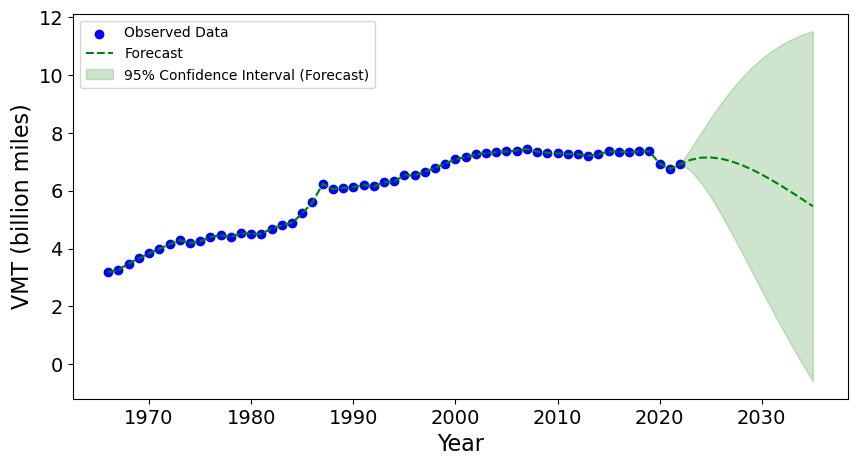

In [7]:
# Define the best kernel and the corresponding scalar value
best_kernel = results[0][3]
best_params = results[0][4]

# Set the best parameters to the best kernel
for param, value in best_params.items():
    setattr(best_kernel, param, value)

# Train a Gaussian Process Regressor with the best kernel
gp_best_combined = GaussianProcessRegressor(kernel=best_kernel, n_restarts_optimizer=10)
gp_best_combined.fit(X, y)

# Make predictions for the entire dataset using the best combined kernel
y_mean_combined, y_cov_combined = gp_best_combined.predict(X, return_cov=True)

# Define the number of years to forecast
num_years_forecast = 13

# Extend the range of x_NHM to cover the forecast period
x_forecast = np.arange(X.min(), X.max() + num_years_forecast + 1).reshape(-1, 1)

# Make predictions for the forecast period using the best combined kernel
y_mean_forecast_combined, y_cov_forecast_combined = gp_best_combined.predict(x_forecast, return_cov=True)

# Plot the observed data, predicted mean with the best combined kernel, and forecast
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='b', label='Observed Data')
# plt.plot(X, y_mean_combined, 'k', lw=2, zorder=9, label='Predicted Mean (Best Kernel)')
# plt.fill_between(X[:, 0], y_mean_combined - 1.96 * np.sqrt(np.diag(y_cov_combined)),
#                  y_mean_combined + 1.96 * np.sqrt(np.diag(y_cov_combined)), alpha=0.8, color='blue', label='95% Confidence Interval')

plt.plot(x_forecast, y_mean_forecast_combined, '--', color='green', label='Forecast')
plt.fill_between(x_forecast[:, 0], y_mean_forecast_combined - 1.96 * np.sqrt(np.diag(y_cov_forecast_combined)),
                 y_mean_forecast_combined + 1.96 * np.sqrt(np.diag(y_cov_forecast_combined)), alpha=0.2, color='green', label='95% Confidence Interval (Forecast)')

plt.xlabel('Year', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('VMT (billion miles)', fontsize=16)  # Adjust fontsize as needed
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust fontsize as needed for major ticks
plt.legend(loc='upper left')
#plt.show()

plt.savefig('../../../figures/forecast-vmt-newhaven——dot.png', dpi=600,bbox_inches='tight')

In [8]:
import string
df_vehicle_re = pd.read_csv('../../../data/raw/mv1.csv')

statewide_vehicle = df_vehicle_re.iloc[14, :]

# the total number of each vehicle type
statewide_automobile = statewide_vehicle.iloc[3]
statewide_buses = statewide_vehicle.iloc[6]
statewide_trucks = statewide_vehicle.iloc[9]
statewide_motorcycle = statewide_vehicle.iloc[12]
statewide_total = statewide_vehicle.iloc[15]

# ratio of each vehicle type to the total
statewide_automobile = int(str(statewide_automobile).translate(str.maketrans('', '', string.punctuation)))
statewide_buses = int(str(statewide_buses).translate(str.maketrans('', '', string.punctuation)))
statewide_trucks = int(str(statewide_trucks).translate(str.maketrans('', '', string.punctuation)))
statewide_motorcycle = int(str(statewide_motorcycle).translate(str.maketrans('', '', string.punctuation)))
statewide_total = int(str(statewide_total).translate(str.maketrans('', '', string.punctuation)))

automobile_rat = statewide_automobile / statewide_total
buses_rat = statewide_buses / statewide_total
trucks_rat = statewide_trucks / statewide_total
motorcycle_rat = statewide_motorcycle / statewide_total

statewide_vehicle = statewide_vehicle.to_numpy()

In [58]:
def emissions(VMT):
    automobile_vmt=VMT*automobile_rat
    buses_vmt=VMT*buses_rat
    trucks_vmt=VMT*trucks_rat
    motorcycle_vmt=VMT*motorcycle_rat

    #average MPG for each vehicle type ( miles per gallons)
    passenger_car_gasoline=24.1*1.1#automobile
    passenger_car_diesel=32.4*1.1
    light_truck_gasoline=18.5*1.1
    light_truck_diesel=22.1*1.1#trucks
    heavy_duty_gasoline=10.13*1.1
    heavy_duty_diesel=12.96*1.1#buses
    motorcycle_gasoline=50*1.1#motorcycle

    #emission factor for different fuels (kg CO2/gallon)( referenced from the ghg tool community module)
    gasoline=8.78*0.9
    diesel=10.21*0.9

    #calculate the fuel consumption in NH MSA
    gaso_consump= automobile_vmt/passenger_car_gasoline+motorcycle_vmt/motorcycle_gasoline
    dies_consump= buses_vmt/heavy_duty_diesel+trucks_vmt/light_truck_diesel

    #calcualte the gasoline and diesel emissions: carbon dioxide emissions only
    gaso_emissions =gaso_consump*gasoline/1000
    dies_emissions =dies_consump*diesel/1000

    #calculate the carbon dioxide consumption(metric tons):
    CO2=gaso_consump*gasoline/1000+dies_consump*diesel/1000

    gaso_auto=automobile_vmt/passenger_car_gasoline
    gaso_motor=motorcycle_vmt/motorcycle_gasoline
    die_trucks=trucks_vmt/light_truck_diesel
    die_buses=buses_vmt/heavy_duty_diesel

    #emission factor for different vehicles : g/miles ( referenced from EPA emission hub)
    # based on year 2005
    CH4_gaso_passenger_car=0.008
    N2O_gaso_passenger_car=0.007

    CH4_gaso_motorcycle=0
    N2O_gaso_motorcycle=0

    CH4_buses=0.005
    N2O_buses=0.005 #( meidum- heavy-duty vehicles in year 2005)

    CH4_trucks=0.001 #( light-duty trucks)
    N2O_trucks=0.001

    #calculate the CH4 emission (metric tons):
    CH4=automobile_vmt*CH4_gaso_passenger_car/1000000+motorcycle_vmt*CH4_gaso_motorcycle/1000000+buses_vmt*CH4_buses/1000000+trucks_vmt*CH4_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_1=CH4*25

    #calculate the N2O emission (metric tons):
    N2O = automobile_vmt*N2O_gaso_passenger_car/1000000 + motorcycle_vmt*N2O_gaso_motorcycle/1000000+buses_vmt*N2O_buses/1000000+trucks_vmt*N2O_trucks/1000000

    #convert to carbon dioxide equavelence:
    CO2_equ_2=N2O*298#define the number 

    #calculation of emissions from each types of vehicle,MMTCO2e(autombile, motorcycle, trucks, buses-NH,HH,BSN)
    automobile = (automobile_vmt/passenger_car_gasoline*gasoline/1000+automobile_vmt*CH4_gaso_passenger_car/1000000*25+automobile_vmt*N2O_gaso_passenger_car/1000000*298)*1000
    motorcycle = (motorcycle_vmt/motorcycle_gasoline*gasoline/1000+motorcycle_vmt*CH4_gaso_motorcycle/1000000*25+motorcycle_vmt*N2O_gaso_motorcycle/1000000*298)*1000
    buses = (buses_vmt/heavy_duty_diesel*diesel/1000+buses_vmt*CH4_buses/1000000*25+buses_vmt*N2O_buses/1000000*298)*1000
    trucks = (trucks_vmt/light_truck_diesel*diesel/1000+trucks_vmt*CH4_trucks/1000000*25+trucks_vmt*N2O_trucks/1000000*298)*1000

    total = automobile+motorcycle+buses+trucks
    
    return total

In [59]:
emissions_forecast = emissions(y_mean_forecast_combined)
y_1d = y.flatten()
emissions_observed = emissions(y_1d)
emissions_forecast_interval = emissions(y_cov_forecast_combined)

In [60]:
emissions_forecast

array([1.08327262, 1.11199696, 1.18523609, 1.24609678, 1.3048944 ,
       1.35853433, 1.41217427, 1.46168804, 1.42867886, 1.44684977,
       1.49810923, 1.51889866, 1.49866467, 1.54183053, 1.53604918,
       1.53659946, 1.59788387, 1.6369831 , 1.66771219, 1.77649492,
       1.90867925, 2.12456489, 2.0622668 , 2.07755893, 2.08737718,
       2.11274823, 2.09377787, 2.14394072, 2.15341143, 2.22518022,
       2.22645457, 2.26491662, 2.3151374 , 2.36419968, 2.41447839,
       2.44092105, 2.47162118, 2.48711605, 2.4973977 , 2.50721595,
       2.51746864, 2.5373658 , 2.5046383 , 2.49096805, 2.48317717,
       2.47547068, 2.47441382, 2.45515247, 2.47492054, 2.5067776 ,
       2.50362989, 2.49949872, 2.507088  , 2.50749607, 2.36169594,
       2.30021224, 2.35399264, 2.4062726 , 2.43228633, 2.43615331,
       2.42147974, 2.39141624, 2.34870952, 2.29574841, 2.23460509,
       2.16707178, 2.09469355, 2.01879752, 1.94051886, 1.86082393])

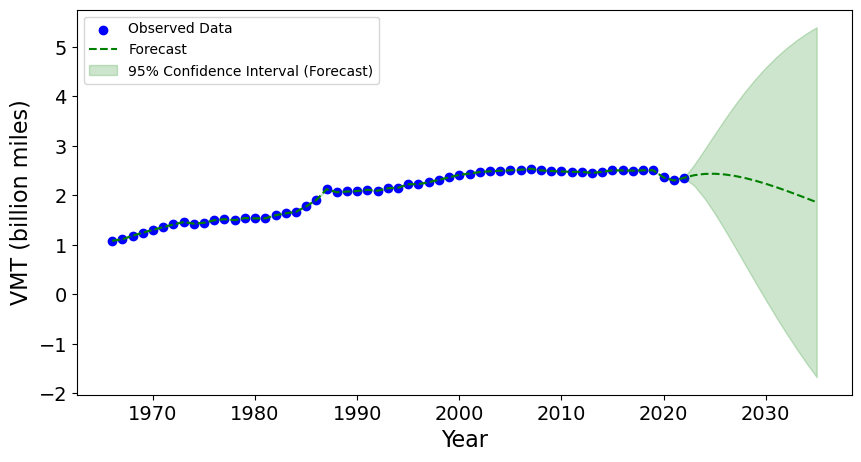

In [61]:
# Plot the observed data, predicted mean with the best combined kernel, and forecast
plt.figure(figsize=(10, 5))
plt.scatter(X, emissions_observed, c='b', label='Observed Data')
# plt.plot(X, y_mean_combined, 'k', lw=2, zorder=9, label='Predicted Mean (Best Kernel)')
# plt.fill_between(X[:, 0], y_mean_combined - 1.96 * np.sqrt(np.diag(y_cov_combined)),
#                  y_mean_combined + 1.96 * np.sqrt(np.diag(y_cov_combined)), alpha=0.8, color='blue', label='95% Confidence Interval')

plt.plot(x_forecast, emissions_forecast, '--', color='green', label='Forecast')
plt.fill_between(x_forecast[:, 0], emissions_forecast - 1.96 * np.sqrt(np.diag(emissions_forecast_interval)),
                 emissions_forecast + 1.96 * np.sqrt(np.diag(emissions_forecast_interval)), alpha=0.2, color='green', label='95% Confidence Interval (Forecast)')

plt.xlabel('Year', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('VMT (billion miles)', fontsize=16)  # Adjust fontsize as needed
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust fontsize as needed for major ticks
plt.legend(loc='upper left')
#plt.show()

plt.savefig('../../../figures/forecast-emisisons-newhaven.png', dpi=600,bbox_inches='tight')

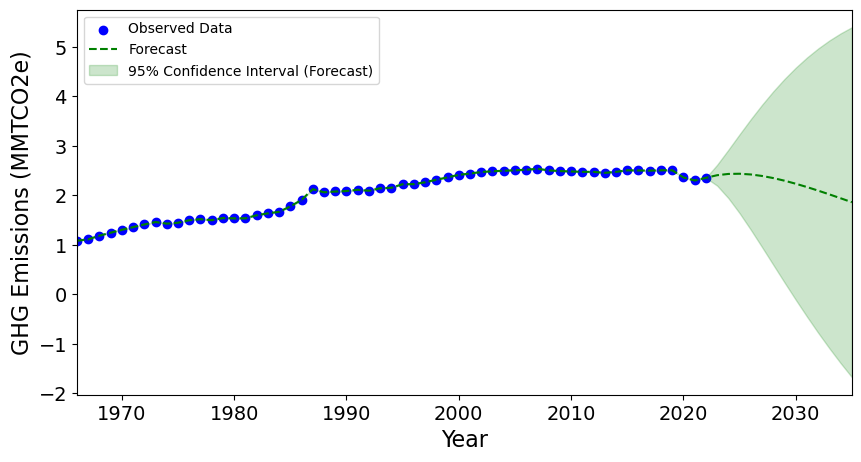

In [62]:
# Assuming start_time and end_time are the desired start and end times respectively

# Calculate the range of x values (years)
x_range = 2035 - 1966

# Plot the observed data, predicted mean with the best combined kernel, and forecast
plt.figure(figsize=(10, 5))
plt.scatter(X, emissions_observed, c='b', label='Observed Data')
# plt.plot(X, y_mean_combined, 'k', lw=2, zorder=9, label='Predicted Mean (Best Kernel)')
# plt.fill_between(X[:, 0], y_mean_combined - 1.96 * np.sqrt(np.diag(y_cov_combined)),
#                  y_mean_combined + 1.96 * np.sqrt(np.diag(y_cov_combined)), alpha=0.8, color='blue', label='95% Confidence Interval')

plt.plot(x_forecast, emissions_forecast, '--', color='green', label='Forecast')
plt.fill_between(x_forecast[:, 0], emissions_forecast - 1.96 * np.sqrt(np.diag(emissions_forecast_interval)),
                 emissions_forecast + 1.96 * np.sqrt(np.diag(emissions_forecast_interval)), alpha=0.2, color='green', label='95% Confidence Interval (Forecast)')

plt.xlabel('Year', fontsize=16)  # Adjust fontsize as needed
plt.ylabel('GHG Emissions (MMTCO2e)', fontsize=16)  # Adjust fontsize as needed
plt.tick_params(axis='both', which='major', labelsize=14)  # Adjust fontsize as needed for major ticks
plt.legend(loc='upper left')

# Set x-axis limits
plt.xlim(1966, 2035)

# Save or show the plot
#plt.show()
plt.savefig('../../../figures/forecast-emisisons-newhaven-scaneir1.png', dpi=600,bbox_inches='tight')


In [63]:
emissions_forecast

array([1.08327262, 1.11199696, 1.18523609, 1.24609678, 1.3048944 ,
       1.35853433, 1.41217427, 1.46168804, 1.42867886, 1.44684977,
       1.49810923, 1.51889866, 1.49866467, 1.54183053, 1.53604918,
       1.53659946, 1.59788387, 1.6369831 , 1.66771219, 1.77649492,
       1.90867925, 2.12456489, 2.0622668 , 2.07755893, 2.08737718,
       2.11274823, 2.09377787, 2.14394072, 2.15341143, 2.22518022,
       2.22645457, 2.26491662, 2.3151374 , 2.36419968, 2.41447839,
       2.44092105, 2.47162118, 2.48711605, 2.4973977 , 2.50721595,
       2.51746864, 2.5373658 , 2.5046383 , 2.49096805, 2.48317717,
       2.47547068, 2.47441382, 2.45515247, 2.47492054, 2.5067776 ,
       2.50362989, 2.49949872, 2.507088  , 2.50749607, 2.36169594,
       2.30021224, 2.35399264, 2.4062726 , 2.43228633, 2.43615331,
       2.42147974, 2.39141624, 2.34870952, 2.29574841, 2.23460509,
       2.16707178, 2.09469355, 2.01879752, 1.94051886, 1.86082393])

In [54]:
x_forecast

array([[1966],
       [1967],
       [1968],
       [1969],
       [1970],
       [1971],
       [1972],
       [1973],
       [1974],
       [1975],
       [1976],
       [1977],
       [1978],
       [1979],
       [1980],
       [1981],
       [1982],
       [1983],
       [1984],
       [1985],
       [1986],
       [1987],
       [1988],
       [1989],
       [1990],
       [1991],
       [1992],
       [1993],
       [1994],
       [1995],
       [1996],
       [1997],
       [1998],
       [1999],
       [2000],
       [2001],
       [2002],
       [2003],
       [2004],
       [2005],
       [2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017],
       [2018],
       [2019],
       [2020],
       [2021],
       [2022],
       [2023],
       [2024],
       [2025],
       [2026],
       [2027],
       [2028],
       [2029],
       [2030],
       [2031],
       [20

In [ ]:
2.2729  2.875